**Import Library**

In [2]:
# !pip install --upgrade numpy scipy
# !pip install PyPortfolioOpt
# !pip install quantstats

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
from pypfopt.plotting import plot_efficient_frontier
import quantstats as qs

**Read Files**

In [5]:
# set files
SET_expected_return = pd.read_csv('../Data/top_10_returns_SET1.csv')
SET_df = pd.read_csv('../Data/SET_main.csv')
set_index = pd.read_csv('../Data/set_index.csv')
set_predict = pd.read_csv('../Data/predictions_set.csv')
# sp500 files 
sp500_expected_return = pd.read_csv('../Data/top_10_returns_sp500.csv')
sp500_df = pd.read_csv('../Data/sp500_main.csv')
sp500_index = pd.read_csv('../Data/sp500_index.csv')
sp500_predict = pd.read_csv('../Data/predictions_sp500.csv')

In [6]:
# Putting the predicted values into the main dataframe instead of the true values 
set_no_date = SET_df.drop(columns=['Date'])
set_no_date.iloc[-360:] = set_predict

In [7]:
# Re_index to use it as a common columns 
set_no_date['Date'] = SET_df['Date']

# Merge the two files 
df = pd.merge(set_no_date, sp500_df,on='Date', how='inner').fillna(0)

# Bring Date columns to front
df = df[['Date'] + [col for col in df.columns if col != 'Date']]

# set Date as index 
df = df.set_index('Date')

**Expected Return**

In [9]:
# Set the forecasted period 
forecasted_df = df.iloc[-360:]

# Calculating daily return for the forecasted period and select only the top 10 stocks that have the highest return
ER = expected_returns.mean_historical_return(forecasted_df).sort_values(ascending=False).head(10)

In [10]:
ER.keys()

Index(['NVDA', 'AVGO', 'META', 'TSLA', 'COST', 'WMT', 'AMZN', 'LLY', 'JPM',
       'TRUE.BK'],
      dtype='object')

In [11]:
# Select only the top 10 stocks that have the highest return
forecasted_df = forecasted_df[ER.keys()]
# calculate the daily return for the forecasted data
forecasted_df_return = forecasted_df.pct_change().dropna()
forecasted_df_return

,NVDA,AVGO,META,TSLA,COST,WMT,AMZN,LLY,JPM,TRUE.BK
Date,,,,,,,,,,
2023-06-02,-0.011139,0.027913,0.000000,0.031081,-0.000019,0.009565,0.012055,0.013379,0.021006,0.000000
2023-06-06,-0.017113,-0.027093,-0.005465,0.034304,0.007160,0.006451,0.018994,0.001673,-0.008044,-0.007576
2023-06-07,-0.030401,0.003329,-0.027737,0.014731,-0.009743,0.001469,-0.042493,-0.015122,0.009689,0.045801
2023-06-08,0.027619,0.014597,0.003718,0.045821,0.017331,0.014467,0.024911,0.021289,0.000284,0.014599
2023-06-09,0.006751,0.000522,0.001398,0.040620,-0.005403,0.006046,-0.006600,0.000853,0.001990,0.014389
...,...,...,...,...,...,...,...,...,...,...
2024-12-03,0.011758,0.009849,0.035120,-0.015878,0.007333,0.009391,0.012956,0.016917,-0.005807,-0.006109
2024-12-04,0.034793,0.014332,0.000212,0.018525,0.008929,0.010052,0.022114,0.020299,-0.005800,0.001041
2024-12-06,-0.018535,0.052591,0.016276,0.087419,0.001705,0.013235,0.040658,-0.003772,0.016270,0.008521


**Calculate Covariance**

In [13]:
cov = risk_models.sample_cov(forecasted_df)

**For Maximum sharpe ratio**

**EfficientFrontier**

In [16]:
# Calculating EfficientFrontier 
ef_max = EfficientFrontier(ER, cov)

In [17]:
# Definning risk free rate by using US 10 Year Treasury Bond Note Yield 
risk_free_rate = 0.0432

In [18]:
# Optimizing weights for Sharpe ratio maximization 
weights_max = ef_max.max_sharpe(risk_free_rate = risk_free_rate)
clean_weights_max = ef_max.clean_weights()

In [19]:
# Printing optimized weights and expected performance for portfolio
total_pct = 0
optimal_weight_max = {}
for key, value in clean_weights_max.items():
    if value > 0:
        optimal_weight_max[key] = value
        print(f"Stock: {key}, Weights: {value}")
        total_pct = total_pct + value
        print(f'Total percentage: {total_pct:.2f}')  

Stock: NVDA, Weights: 0.07722
Total percentage: 0.08
Stock: META, Weights: 0.02864
Total percentage: 0.11
Stock: COST, Weights: 0.0816
Total percentage: 0.19
Stock: WMT, Weights: 0.26167
Total percentage: 0.45
Stock: LLY, Weights: 0.0181
Total percentage: 0.47
Stock: JPM, Weights: 0.13771
Total percentage: 0.60
Stock: TRUE.BK, Weights: 0.39507
Total percentage: 1.00


In [20]:
optimal_weight_max

{'NVDA': 0.07722,
 'META': 0.02864,
 'COST': 0.0816,
 'WMT': 0.26167,
 'LLY': 0.0181,
 'JPM': 0.13771,
 'TRUE.BK': 0.39507}

In [21]:
# optimal_weight_max = np.array(list(optimal_weight_max.values()))

In [22]:
expected_return, risk, sharpe = ef_max.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

Expected annual return: 62.1%
Annual volatility: 10.7%
Sharpe Ratio: 5.41


In [23]:
# Creating new portfolio with optimized weights
optimized_portfolio_df = pd.DataFrame()

# Calculate the optimized portfolio's daily returns
for stock, weight in optimal_weight_max.items():
    optimized_portfolio_df[stock] = forecasted_df_return[stock] * weight

# Sum the returns 
optimized_portfolio_df['Total'] = optimized_portfolio_df.sum(axis=1)  # to calculate sum of row

# select only total 
optimized_portfolio_max_sharpe = optimized_portfolio_df[['Total']]

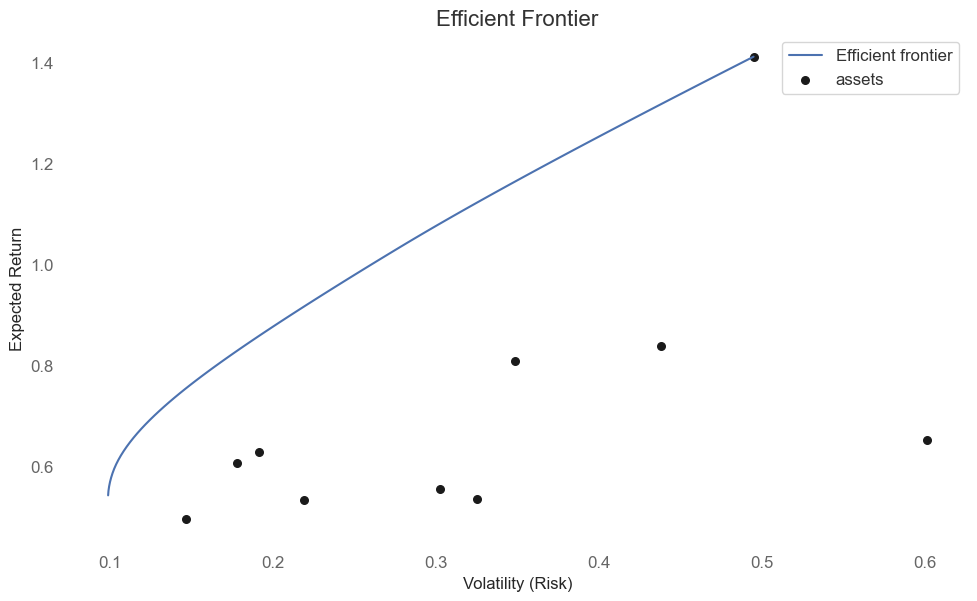

In [24]:
# Create a new EfficientFrontier instance for plotting
ef_for_plot = EfficientFrontier(ER, cov)
plt.figure(figsize=(10, 6))
ax = plot_efficient_frontier(ef_for_plot, show_assets=True)
plt.title("Efficient Frontier", fontsize=16)
plt.xlabel("Volatility (Risk)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.grid()
plt.show()

**Random Portfolio**

In [26]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(ER)), n_samples)
rets = w.dot(ER)
stds = np.sqrt((w.T * (cov @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.7187174  0.67457101 0.71850537 ... 0.67045971 0.86364993 0.74949537]
Sample portfolio volatilities: 0       0.187032
1       0.215679
2       0.206286
3       0.233588
4       0.180754
          ...   
9995    0.222757
9996    0.175914
9997    0.191612
9998    0.234240
9999    0.311912
Length: 10000, dtype: float64


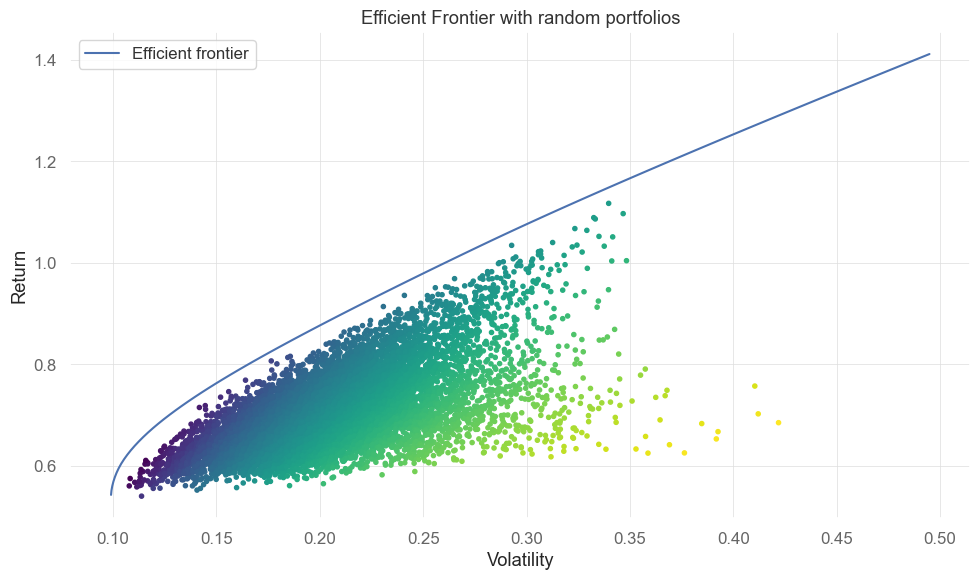

In [27]:
# Plot efficient frontier with Monte Carlo simulation
ef = EfficientFrontier(ER, cov)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(ER, cov)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

**For Minimum votality portfolio**

In [29]:
# Calculating EfficientFrontier 
ef_min = EfficientFrontier(ER, cov)

In [30]:
# Optimizing weights for Minimum votality portfolio 
weights_min = ef_min.min_volatility()
clean_weights_min = ef_min.clean_weights()

In [31]:
# Printing optimized weights and expected performance for portfolio
total_pct = 0
optimal_weight_min = {}
for key, value in clean_weights_min.items():
    if value > 0:
        optimal_weight_min[key] = value
        print(f"Stock: {key}, Weights: {value}")
        total_pct = total_pct + value
        print(f'Total percentage: {total_pct:.2f}')

Stock: META, Weights: 0.00012
Total percentage: 0.00
Stock: COST, Weights: 0.11671
Total percentage: 0.12
Stock: WMT, Weights: 0.19165
Total percentage: 0.31
Stock: AMZN, Weights: 0.04385
Total percentage: 0.35
Stock: LLY, Weights: 0.05086
Total percentage: 0.40
Stock: JPM, Weights: 0.14898
Total percentage: 0.55
Stock: TRUE.BK, Weights: 0.44782
Total percentage: 1.00


In [32]:
optimal_weight_min

{'META': 0.00012,
 'COST': 0.11671,
 'WMT': 0.19165,
 'AMZN': 0.04385,
 'LLY': 0.05086,
 'JPM': 0.14898,
 'TRUE.BK': 0.44782}

In [33]:
optimal_weight_min = np.array(list(optimal_weight_min.values()))

In [34]:
expected_return, risk, sharpe = ef_min.portfolio_performance(verbose=True)

Expected annual return: 54.3%
Annual volatility: 9.9%
Sharpe Ratio: 5.48


**Create the beachmark using SET Index and S&P500 Index**

In [36]:
# Standardize the 'Date' column
set_index['Date'] = pd.to_datetime(set_index['Date']).dt.date
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'],utc=True).dt.date

In [37]:
# Merge the dataframe from SET and S&P Index on 'Date'
benchmark_df = pd.merge(set_index, sp500_index,on='Date', how='inner')
benchmark_df = benchmark_df.rename(columns = {'Close_x':'close_set', 'Close_y':'close_sp500'})
benchmark_df = benchmark_df[['close_set' , 'close_sp500', 'Date']]
benchmark_df = benchmark_df.set_index('Date')

In [38]:
# calculating the return on indices 
set_only = benchmark_df['close_set'].to_frame()
sp500_only = benchmark_df['close_sp500'].to_frame()

In [39]:
# Create weight based on the stocks in portfolio 
count_set = 0
count_sp500 = 0
for stock in ER.keys():
    if stock in SET_df.columns:
        count_set = count_set + 1
    else:
        stock in sp500_df.columns
        count_sp500 = count_sp500 + 1

weights_set = count_set/(count_set+count_sp500)
weights_sp500 = 1-weights_set

print(f"Total stocks in SET is: {count_set}")
print(f"Total stocks in SP500 is: {count_sp500}")

Total stocks in SET is: 1
Total stocks in SP500 is: 9


In [40]:
# Creating benchmark 
benchmark = weights_sp500*sp500_only[-360:]['close_sp500'] + weights_set*set_only[-360:]['close_set']
benchmark = benchmark.pct_change().dropna()
benchmark = benchmark.to_frame()
benchmark = benchmark.rename(columns = {'0': 'weighted benchmark'})

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-06-08   2023-06-08
End Period                 2024-12-11   2024-12-11
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          40.71%       98.76%
CAGR﹪                     16.87%       36.83%

Sharpe                     2.03         4.62
Prob. Sharpe Ratio         99.0%        100.0%
Smart Sharpe               1.58         3.6
Sortino                    2.95         8.32
Smart Sortino              2.3          6.48
Sortino/√2                 2.09         5.89
Smart Sortino/√2           1.63         4.58
Omega                      2.11         2.11

Max Drawdown               -10.3%       -10.49%
Longest DD Days            129          126
Volatility (ann.)          12.27%       10.65%
R^2                        0.37         0.37
Information Ratio          0.15         0.15
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-09-26,2023-12-14,2024-01-29,126,-10.485054,-10.420793
2,2024-07-11,2024-08-05,2024-08-09,30,-4.951361,-3.822049
3,2023-08-08,2023-08-17,2023-09-13,37,-3.980498,-3.708488
4,2023-06-22,2023-06-29,2023-07-10,19,-3.471313,-3.279672
5,2024-03-22,2024-04-30,2024-05-08,48,-3.438223,-3.355063


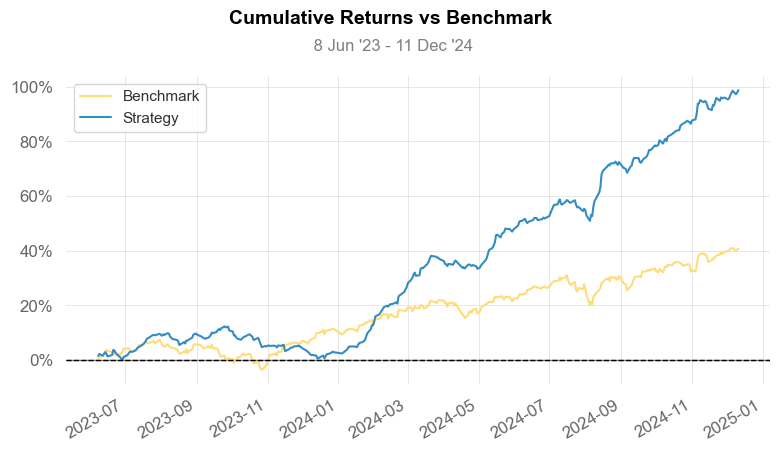

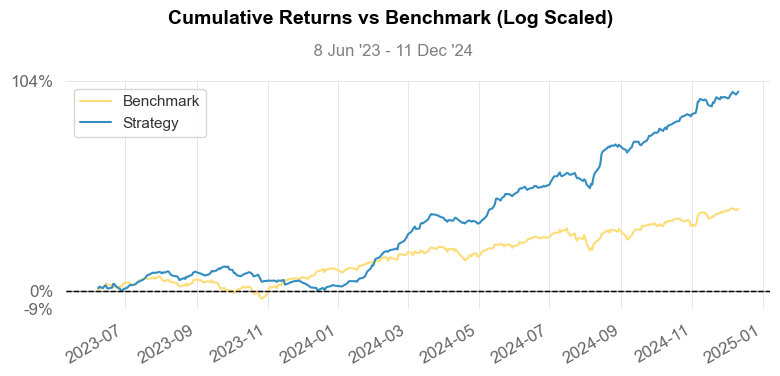

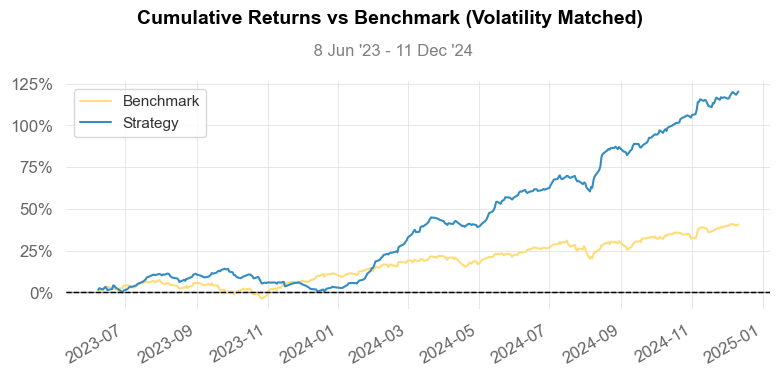

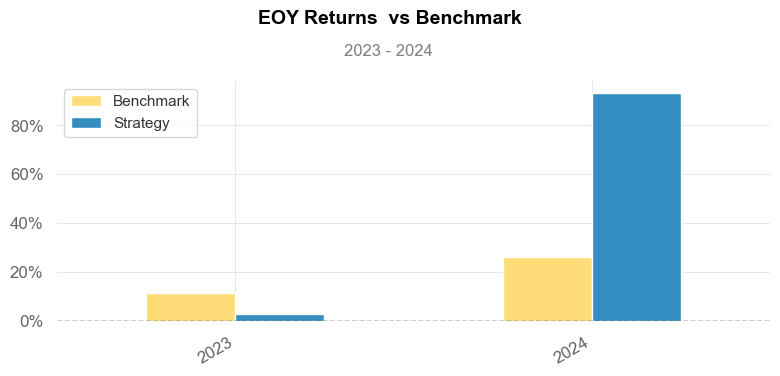

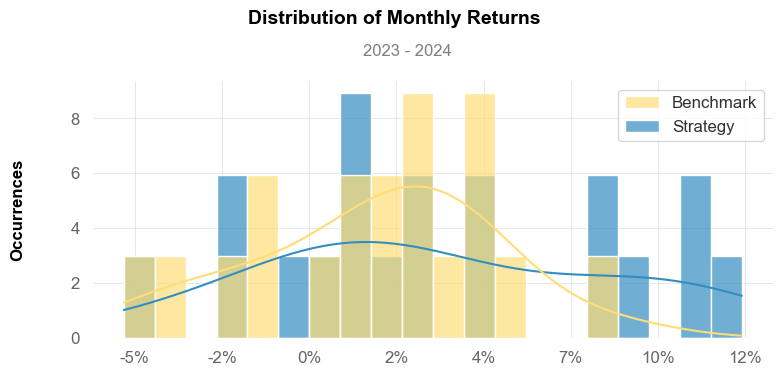

/opt/anaconda3/lib/python3.12/site-packages/quantstats/_plotting/core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [41]:
# New reports comparing the optimized portfolio to the first portfolio constructed
optimized_portfolio_max_sharpe.index = pd.to_datetime(optimized_portfolio_max_sharpe.index)
benchmark.index = pd.to_datetime(benchmark.index)

# Convert into series 
optimized_portfolio_max_sharpe = optimized_portfolio_max_sharpe.squeeze() 
benchmark = benchmark.squeeze()

qs.reports.full(optimized_portfolio_max_sharpe,benchmark=benchmark)

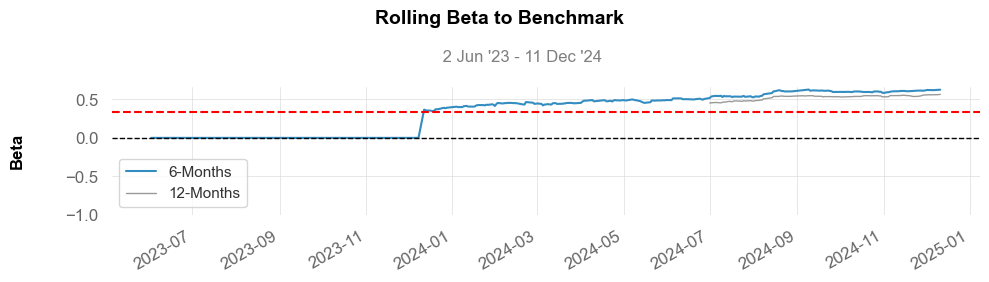

In [77]:
# Rolling beta comparison
qs.plots.rolling_beta(returns=optimized_portfolio_max_sharpe, benchmark=benchmark)

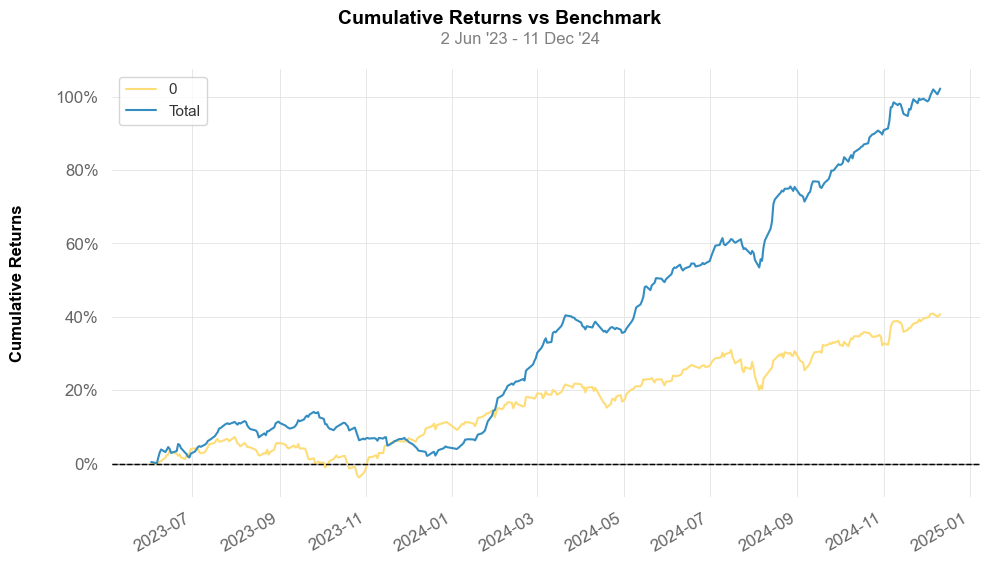

In [55]:
qs.plots.returns(optimized_portfolio_max_sharpe,benchmark=benchmark)